### celeba GAN 모형

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

# True
# 0
# 1
# NVIDIA GeForce GTX 1050 Ti

True
0
1
NVIDIA GeForce GTX 1050


In [2]:
# gpu 사용 가능 여부 확인

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: NVIDIA GeForce GTX 1050


device(type='cuda')

In [3]:
#데이터셋 클래스

from torch.utils.data import Dataset
import h5py
import numpy as np  
import matplotlib.pyplot as plt

class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['c:/workspace3/data/images/celeba/img_align_celeba']        

    def __len__(self):

        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()

        img = np.array(self.dataset[str(index)+'.jpg'])

        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(np.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')

In [4]:
celeba_dataset = CelebADataset('c:/workspace3/data/images/celeba/celeba_aligned_small.h5py')

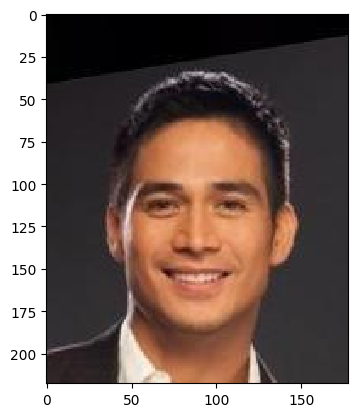

In [5]:
celeba_dataset.plot_image(11)

In [6]:
# 랜덤 데이터 생성 함수

def generate_random_image(size):
    random_data = torch.rand(size)

    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)

    return random_data

In [7]:
import torch.nn as nn

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.view(self.shape)  

In [8]:
# 판별 모형

import pandas as pd

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):

        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1

        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        if self.counter % 1000 == 0:
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [9]:
%%time

#판별 모형 테스트(오래 걸림, 40~50분)
D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 가짜 데이터
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: total: 50min 9s
Wall time: 9min 19s


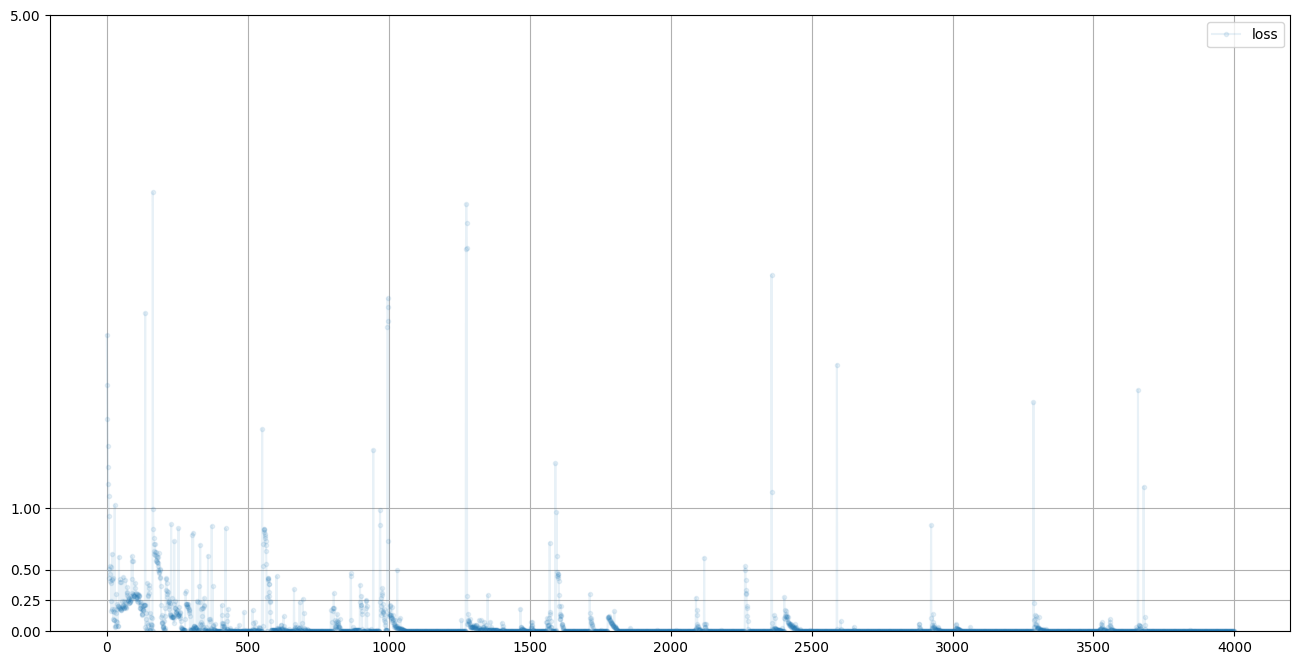

In [10]:
# 판독모형의 loss

D.plot_progress()

In [11]:
# 판독모델 테스트

import random

# test real data
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )

# test fake data
for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )

0.9990485310554504
0.9999058246612549
0.9999368190765381
0.9996080994606018
0.0002542865404393524
0.0002423388505121693
0.00023751999833621085
0.0002520114940125495


In [12]:
# 생성 모델

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
#                      100개 랜덤숫자
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218,178,3))
        )
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):        

        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)        
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)

        self.counter += 1

        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

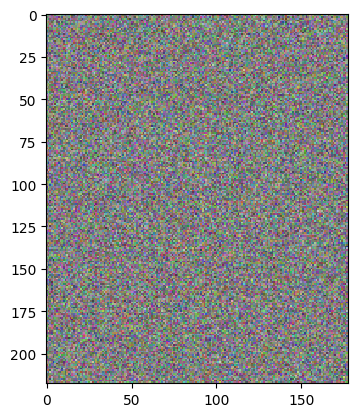

In [13]:
#생성모델 테스트

G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [14]:
%%time

# 판독모형, 생성모형 생성

D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

epochs = 2

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)
  for image_data_tensor in celeba_dataset:
    # 판별모형 훈련(true)
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 판별모형 훈련(false)
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 생성모형 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

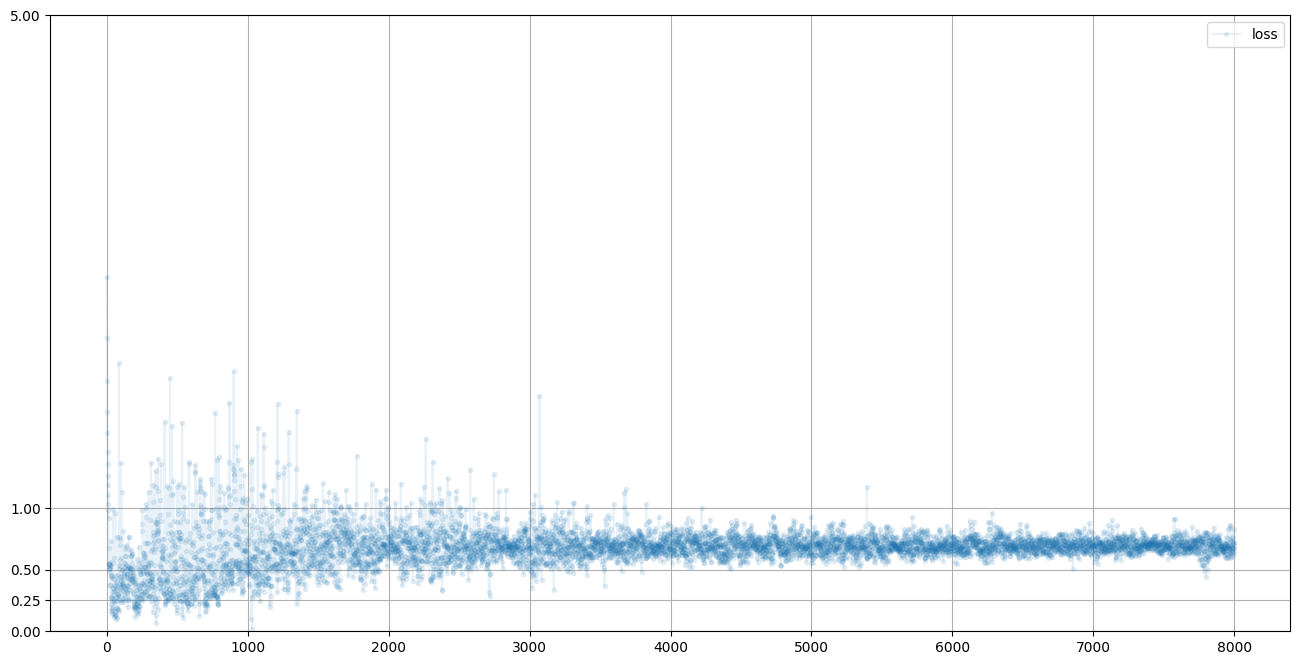

In [15]:
D.plot_progress()

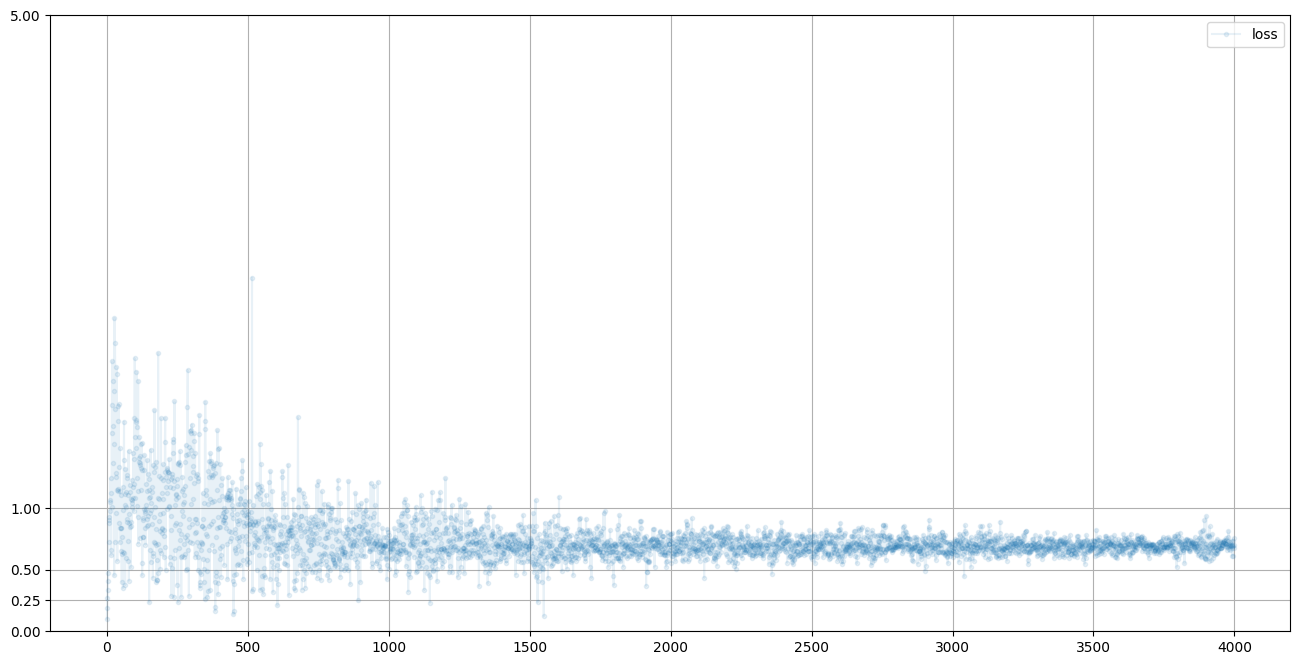

In [16]:
G.plot_progress()

In [17]:
torch.save(G,'c:/data/model/final_celeba_G_2.h5')